# Purpose
The purpose of this notebook is to generate supplemental figure 3, which focuses on evaluations of the vocal detection model. This notebook required a das kernel (select "Kernel" from the jupyter menu above -> "Change Kernel" -> "DAS"). See the README for how to generate this.

# Preliminaries

## load packages

In [1]:
%matplotlib inline
%autosave 60
%load_ext autoreload
%autoreload 2

#filesystem
import re
import os
import glob
from pathlib import Path
from tqdm import tqdm

#plotting
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
from dateutil import rrule
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, Normalize

#data
import numpy as np
import pandas as pd
import random
import ast
import pickle
import networkx as nx
from datetime import datetime, timedelta
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.ndimage import gaussian_filter
from scipy.io import wavfile

# custom modules
from src import parameters, timestamps, annotation, segmentation, spectrogramming


Autosaving every 60 seconds


## paths

In [2]:
# project root - to reproduce, just change root to the full path to mouse_barn_audiomoth on your computer
#root = '/path/to/proc_B_data_submission/'
root = '/Users/jourjine/Desktop/lindholm/barn_manuscript_final/public_repositories/wild-mus-vocal-ecology'

# The das model
model_ID = '20230219_120047'

# path to save the figures
path_to_save = ''

# path to vocal_events
vocal_events_path = os.path.join(root,'data', 'segments', 'vocal_events')

# annotations
annotations_root = os.path.join(root, 'annotations')
annotated_vocal_counts_path = os.path.join(annotations_root, 'counts_test')
annotated_vocal_segments_path = os.path.join(annotations_root, 'segments_test')
annotated_vocal_segments_wav_dir = os.path.join(annotations_root, 'segments_test_wav_file')
annotated_vocal_segments_features_dir = os.path.join(annotations_root, 'segment_annotations_acoustic_features')

# trained DAS models
models_root = os.path.join(root, 'models')
vocalization_colors = os.path.join(root, 'parameters', 'json_files','vocalization_colors.json')

# example pictures
path_to_workflow_pic = os.path.join(root,'parameters', 'images','segmentation_workflow_diagram.jpeg')
path_to_audio_moth = os.path.join(root, 'parameters', 'images', 'audiomoth_in_case.jpeg')
path_to_audio_moth_in_case_open = os.path.join(root, 'parameters','images', 'protective_case_open.jpeg')
path_to_audio_moth_in_case_closed = os.path.join(root, 'parameters', 'images', 'protective_case_closed.jpeg')
path_to_audio_moth_in_action = os.path.join(root, 'parameters', 'images','audiomoth_on_box.jpeg')
path_to_audio_moth_with_barn_interior = os.path.join(root, 'parameters', 'images','barn_interior_with_audiomoths.jpeg')
path_to_example_wav_for_spectrogram = os.path.join(root, 'parameters', 'audio_files', '20220706-20220708_box22_moth00_20220708_065900.wav')

#Training results
model_save_name = os.path.join(models_root, model_ID)

# Get the data

## Get the model to evaluate 


In [3]:
# #from DAS
import das
import flammkuchen
import librosa
import librosa.display

res = flammkuchen.load(f'{model_save_name}_results.h5')

## Show annotations this model was trained on

In [4]:
annotated_df = annotation.count_annotated(os.path.join(annotations_root, 'segment_annotations'))

/Users/jourjine/Desktop/lindholm/barn_manuscript_final/public_repositories/wild-mus-vocal-ecology/src/annotation.py:86: RuntimeWarning: All-NaN axis encountered
  assert (np.nanmin(df['start_seconds'])) >= 0 or (np.isnan(np.nanmin(df['start_seconds']))), "Some annotated start times are negative"
/Users/jourjine/Desktop/lindholm/barn_manuscript_final/public_repositories/wild-mus-vocal-ecology/src/annotation.py:93: RuntimeWarning: All-NaN axis encountered
  assert (np.nanmin(df['duration']) >= 0) or (np.isnan(np.nanmin(df['duration']))), "Some start times come after corresponding stop times"
/Users/jourjine/Desktop/lindholm/barn_manuscript_final/public_repositories/wild-mus-vocal-ecology/src/annotation.py:96: RuntimeWarning: All-NaN axis encountered
  if np.nanmax(df['duration'].loc[df['name'] == 'cry']) > 2:
/Users/jourjine/Desktop/lindholm/barn_manuscript_final/public_repositories/wild-mus-vocal-ecology/src/annotation.py:98: RuntimeWarning: All-NaN axis encountered
  if np.nanmax(df['d

/Users/jourjine/Desktop/lindholm/barn_manuscript_final/public_repositories/wild-mus-vocal-ecology/src/annotation.py:86: RuntimeWarning: All-NaN axis encountered
  assert (np.nanmin(df['start_seconds'])) >= 0 or (np.isnan(np.nanmin(df['start_seconds']))), "Some annotated start times are negative"
/Users/jourjine/Desktop/lindholm/barn_manuscript_final/public_repositories/wild-mus-vocal-ecology/src/annotation.py:93: RuntimeWarning: All-NaN axis encountered
  assert (np.nanmin(df['duration']) >= 0) or (np.isnan(np.nanmin(df['duration']))), "Some start times come after corresponding stop times"
/Users/jourjine/Desktop/lindholm/barn_manuscript_final/public_repositories/wild-mus-vocal-ecology/src/annotation.py:96: RuntimeWarning: All-NaN axis encountered
  if np.nanmax(df['duration'].loc[df['name'] == 'cry']) > 2:
/Users/jourjine/Desktop/lindholm/barn_manuscript_final/public_repositories/wild-mus-vocal-ecology/src/annotation.py:98: RuntimeWarning: All-NaN axis encountered
  if np.nanmax(df['d

In [5]:
print('Total squeaks annotated (count):', annotated_df['cry_count'].sum())
print('Total squeaks annotated (seconds):', annotated_df['cry_duration'].sum(), '\n')
print('Total USVs annotated (count):', annotated_df['USV_count'].sum())
print('Total USVs annotated (seconds):', annotated_df['USV_duration'].sum(), '\n')
print('Non-vocal duration annotation (seconds):', 55*len(annotated_df['source_file'].unique()) - (annotated_df['USV_duration'].sum() + annotated_df['cry_duration'].sum()))

Total squeaks annotated (count): 2137
Total squeaks annotated (seconds): 197.368822248939 

Total USVs annotated (count): 2172
Total USVs annotated (seconds): 112.2823630791354 

Non-vocal duration annotation (seconds): 11790.348814671926


## Evaluation of vocal detection and labeling

### Training and validation loss

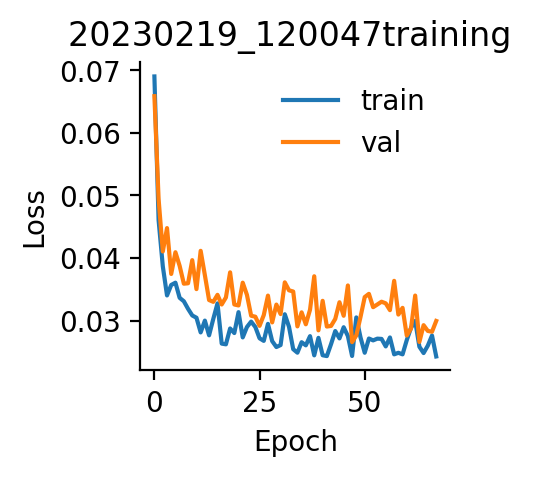

In [6]:
plt.figure(figsize=[2,2], dpi= 200)
plt.title(model_save_name.split('/')[-1]+'training ')
plt.plot(res['fit_hist']['loss'], label='train')
plt.plot(res['fit_hist']['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')

sns.despine()
plt.legend(frameon=False)

### Labeling evaluation
- Evaluation of how well the model labels each of the spectrogram chunks it sees as squeak, USV, or "noise" (no vocalization)
- This data is automatically generated by DAS

In [7]:
all_labels_eval = pd.DataFrame()

F1_scores = [ res['classification_report']['cry']['f1-score'], res['classification_report']['USV']['f1-score'], res['classification_report']['noise']['f1-score'] ]
precisions = [ res['classification_report']['cry']['precision'], res['classification_report']['USV']['precision'], res['classification_report']['noise']['precision'] ]
recalls = [ res['classification_report']['cry']['recall'], res['classification_report']['USV']['recall'], res['classification_report']['noise']['recall'] ]        
voc_types = ['cry', 'USV', 'noise']
model = ['v2']*3

all_labels_eval['F1_score'] = F1_scores
all_labels_eval['precision'] = precisions
all_labels_eval['recall'] = recalls
all_labels_eval['voc_type'] = voc_types
all_labels_eval['model'] = model_ID

for voc_type in all_labels_eval['voc_type'].unique():
    print(voc_type)
    print(f"\tLabeling precision: {all_labels_eval['precision'][all_labels_eval['voc_type'] == voc_type].iloc[0]:.4f}")
    print(f"\tLabeling recall: {all_labels_eval['recall'][all_labels_eval['voc_type'] == voc_type].iloc[0]:.4f}")
    print(f"\tLabeling F1 Score: {all_labels_eval['F1_score'][all_labels_eval['voc_type'] == voc_type].iloc[0]:.4f}")

cry
	Labeling precision: 0.8450
	Labeling recall: 0.8524
	Labeling F1 Score: 0.8487
USV
	Labeling precision: 0.8317
	Labeling recall: 0.7281
	Labeling F1 Score: 0.7764
noise
	Labeling precision: 0.9957
	Labeling recall: 0.9967
	Labeling F1 Score: 0.9962


### Detection evaluation
- Evaluation of how well the model detects vocalizations (squeak or USV)

In [9]:
# the predicted labels 
labels_pred = res['labels_pred']

# the actual labels in the test set
labels_actual = res['labels_test']

# binarize to calculate metrics on vocal detection
vocs_pred = [1 if x != 0 else 0 for x in labels_pred] 
vocs_actual = [1 if x != 0 else 0 for x in labels_actual]

# calculate true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN)
TP = sum(1 for a, p in zip(vocs_actual, vocs_pred) if a == 1 and p == 1)
TN = sum(1 for a, p in zip(vocs_actual, vocs_pred) if a == 0 and p == 0)
FP = sum(1 for a, p in zip(vocs_actual, vocs_pred) if a == 0 and p == 1)
FN = sum(1 for a, p in zip(vocs_actual, vocs_pred) if a == 1 and p == 0)

# calculate precison, recall, and F1 for vocal detection
precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
F1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

print(f"Detection precision: {precision:.4f}")
print(f"Detection recall: {recall:.4f}")
print(f"Detection F1 Score: {F1:.4f}")

Detection precision: 0.8631
Detection recall: 0.8294
Detection F1 Score: 0.8459


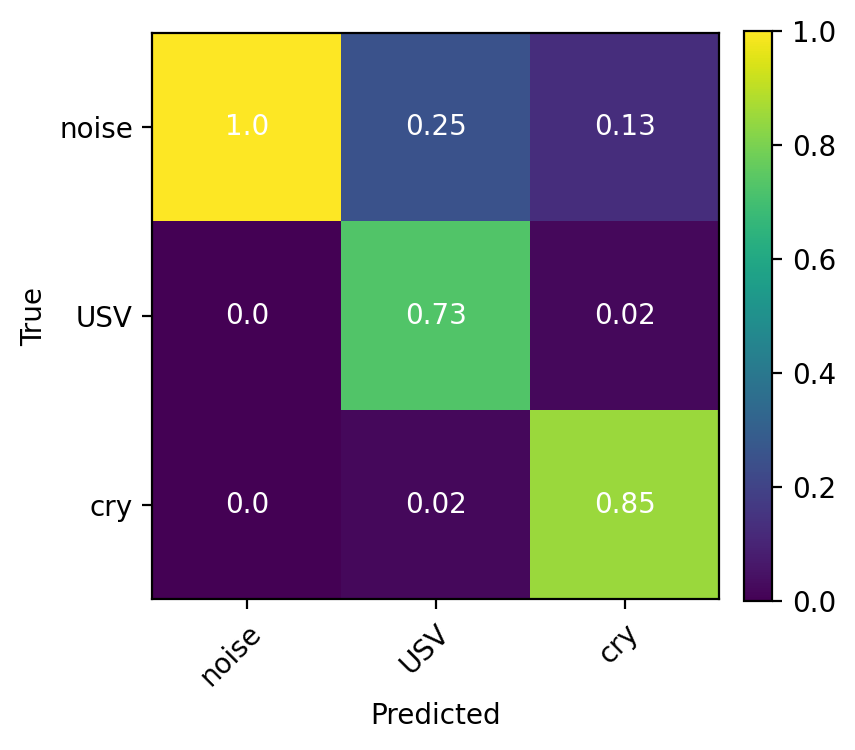

In [10]:
#show a heatmap

labels = ['noise', 'USV', 'cry']
figure, ax = plt.subplots(nrows=1, ncols=1, dpi=200, figsize=[4,4])

confusion_matrix = res['confusion_matrix'].T/res['confusion_matrix'].T.sum(axis=0)
confusion_matrix = np.round(confusion_matrix, decimals=2)

cax = ax.imshow(confusion_matrix, cmap='viridis', aspect='equal')
cbar = figure.colorbar(cax, fraction=0.046, pad=0.04)
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, confusion_matrix[i, j],
                       ha="center", va="center", color="w", fontsize=10)

ax.set_xlabel('Predicted')
ax.set_ylabel('True')

plt.show()

## Evaluation of vocal counts per wav file
- Evaluation of how well the model counts the number of vocalizations in each 55s wav file

In [11]:
#get the hand counted 20220708 recording and corresponding predictions
handcounts_path = glob.glob(os.path.join(annotated_vocal_counts_path,'*/*hand_counts.csv'))[0]
handcount_df = pd.read_csv(handcounts_path)
                          
#get the das prediction for this recording                          
predictions_path = glob.glob(os.path.join(annotated_vocal_counts_path,'*/*predicted_counts.csv'))[0]
predicted_count_df = pd.read_csv(predictions_path)

#merge predicted and actual on minute column
handcount_df['minute'] = handcount_df['minute'].astype(str)
predicted_count_df['minute'] = predicted_count_df['minute'].astype(str)
comparison_df = predicted_count_df.merge(handcount_df, how='right', on='minute')[['minute', 'predicted_squeak_count', 'actual_squeak_count', 'predicted_USV_count', 'actual_USV_count']]
comparison_df['squeak_error'] = comparison_df['actual_squeak_count'] - comparison_df['predicted_squeak_count']
comparison_df['USV_error'] = comparison_df['actual_USV_count'] - comparison_df['predicted_USV_count']

# calculate errors
errors = []
voc_type = []
actual_counts = []
predicted_counts = []

for row in comparison_df.index:
    squeak_predicted = comparison_df['predicted_squeak_count'].iloc[row]
    squeak_actual = comparison_df['actual_squeak_count'].iloc[row]
    squeak_error = squeak_actual-squeak_predicted
    errors.append(squeak_error)
    voc_type.append('squeak')
    actual_counts.append(squeak_actual)
    predicted_counts.append(squeak_predicted)
    USV_predicted = comparison_df['predicted_USV_count'].iloc[row]
    USV_actual = comparison_df['actual_USV_count'].iloc[row]
    USV_error = USV_actual-USV_predicted
    errors.append(USV_error)
    voc_type.append('USV')
    actual_counts.append(USV_actual)
    predicted_counts.append(USV_predicted)

    
errors_df = pd.DataFrame()
errors_df['error'] = errors
errors_df['voc_type'] = voc_type
errors_df['actual_count'] = actual_counts
errors_df['predicted_count'] = predicted_counts


In [12]:
actual_USV = comparison_df['actual_USV_count'].sum()
predicted_USV = comparison_df['predicted_USV_count'].sum()
print((actual_USV - predicted_USV)/actual_USV)

0.028985507246376812


In [13]:
actual_squeak = comparison_df['actual_squeak_count'].sum()
predicted_squeak = comparison_df['predicted_squeak_count'].sum()
print((actual_squeak - predicted_squeak)/ actual_squeak)

-0.16363636363636364


In [14]:
#mean error for squeaks
mean_error_squeak = comparison_df['squeak_error'].mean()

#mean error for USVs
mean_error_USV = comparison_df['USV_error'].mean()

print("Mean Errors:")
print(f"Squeak = {mean_error_squeak}")
print(f"USV = {mean_error_USV}")

Mean Errors:
Squeak = -0.3564356435643564
USV = 0.039603960396039604


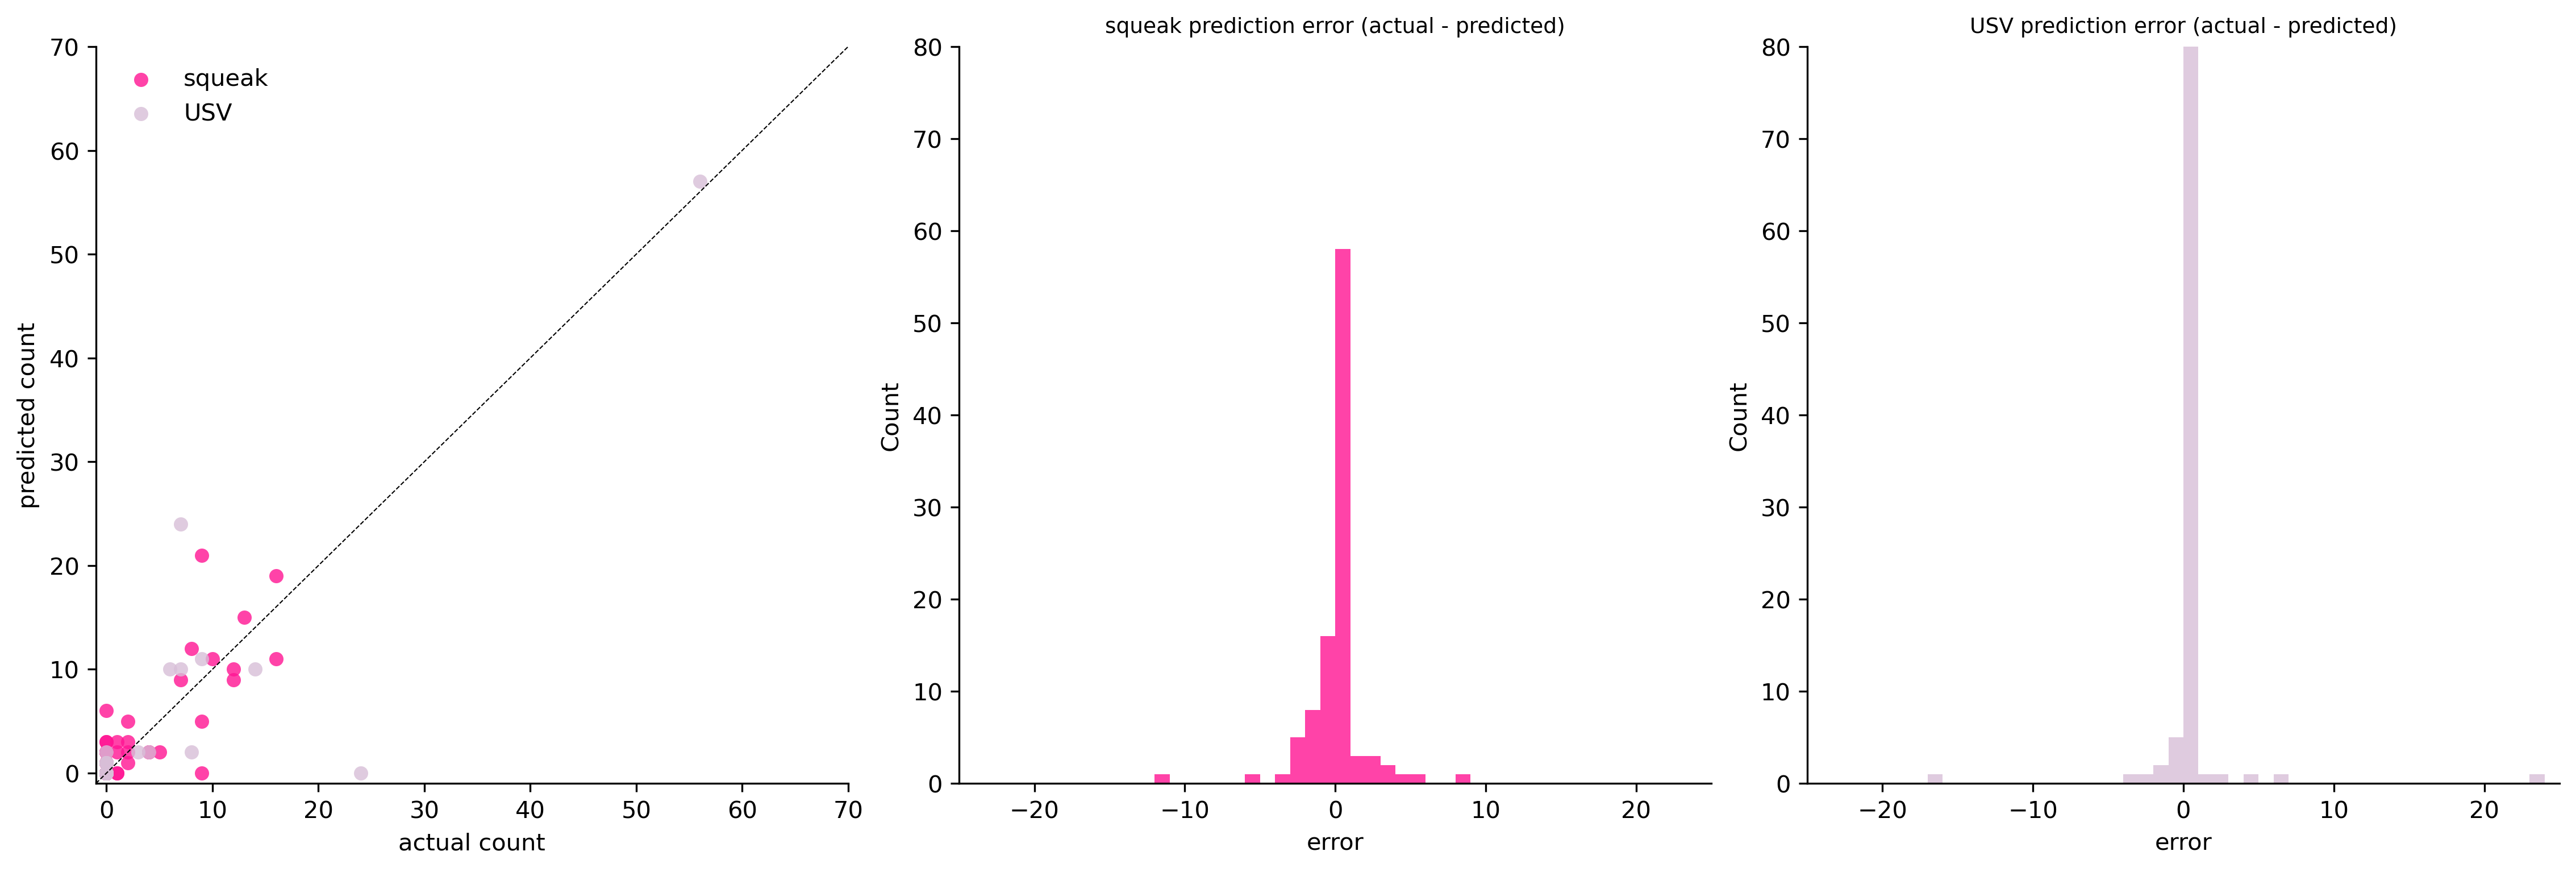

In [15]:
fig, axes = plt.subplots(nrows=1, 
                         ncols=3, 
                         figsize=[15,5], 
                       dpi=300, 
                         constrained_layout=True)

voc_colors = {'squeak':'deeppink', 'USV':'thistle'}
axes[0].scatter(x = comparison_df['actual_squeak_count'], 
                y = comparison_df['predicted_squeak_count'], 
                color = 'deeppink', 
                alpha = 0.8, 
                linewidth = 0)
axes[0].scatter(x = comparison_df['actual_USV_count'], 
                y = comparison_df['predicted_USV_count'], 
                color = 'thistle', 
                alpha = 0.8, 
                linewidth = 0)

sns.histplot(data=errors_df.loc[errors_df['voc_type']=='squeak'], 
             x='error', 
             hue='voc_type',
             ax=axes[1], 
             palette = voc_colors, 
             linewidth=0, 
             alpha=.8, 
             binwidth=1, 
             legend=False)

sns.histplot(data=errors_df.loc[errors_df['voc_type']=='USV'], 
             x='error', 
             hue='voc_type',
             ax=axes[2], 
             palette = voc_colors, 
             linewidth=0, 
             alpha=.8, 
             binwidth=1, legend=False)

axes[0].set_xlim([-1,70])
axes[0].set_ylim([-1,70])
axes[0].legend(['squeak', 'USV'], frameon=False)
axes[0].set_xlabel('actual count')
axes[0].set_ylabel('predicted count')
axes[0].axline((0,0), slope=1, color = 'black', linestyle = '--', linewidth=.5)
axes[1].set_title('squeak prediction error (actual - predicted)', fontsize=9)
axes[1].set_ylim([0,80])
axes[1].set_xlim([-25,25])
axes[2].set_title('USV prediction error (actual - predicted)', fontsize=9)
axes[2].set_ylim([0,80])
axes[2].set_xlim([-25,25])
# plt.suptitle('error = actual count - predicted count', fontsize=12)


sns.despine()

## Example segmentation of an annotated wav file not in the test set

In [16]:
#choose thresholds and model
segment_thresholds = [0.8] 
model_ID = '20230219_120047'

# parameters used for actual prediction
seg_params = {
    'min_dur':0.01, # minimum syllable duration
    'min_intersyllable': .005,
    'segment_thres':0.8, 
    'model_ID':model_ID
}

path_to_annotation = os.path.join(annotated_vocal_segments_path, '20220706-20220708_20220708_box22_moth00_062900_annotations.csv')
path_to_wav = os.path.join(annotated_vocal_segments_wav_dir, 'moth00_20220708_062900.wav')


In [17]:
#predict
from src import evaluate
predicted_segments_df = evaluate.predict(path_to_wav = path_to_wav,
                                         path_to_annotation = path_to_annotation,
                                         models_root = models_root,  
                                         model_ID = model_ID, 
                                         thresholds=[seg_params['segment_thres']], 
                                         min_dur=seg_params['min_dur'], 
                                         min_intersyllable=seg_params['min_intersyllable'], 
                                         new_das = True, 
                                         save = False)


loading model...
predicting with threshold = 0.8 ...


/Users/jourjine/miniconda3/envs/test_das_20250311/lib/python3.9/site-packages/das/data.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/82 [00:00<?, ?it/s]

2025-04-10 13:52:25.457199: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


done.


In [18]:
# predicted by above cell
predicted = predicted_segments_df[0]

# annotated
true_df = pd.read_csv(path_to_annotation)
true_df['name'] = true_df['name'].map({'USV':'USV', 'whistle':'USV', 'cry':'squeak'})
true_df['duration'] = true_df['stop_seconds'] - true_df['start_seconds']

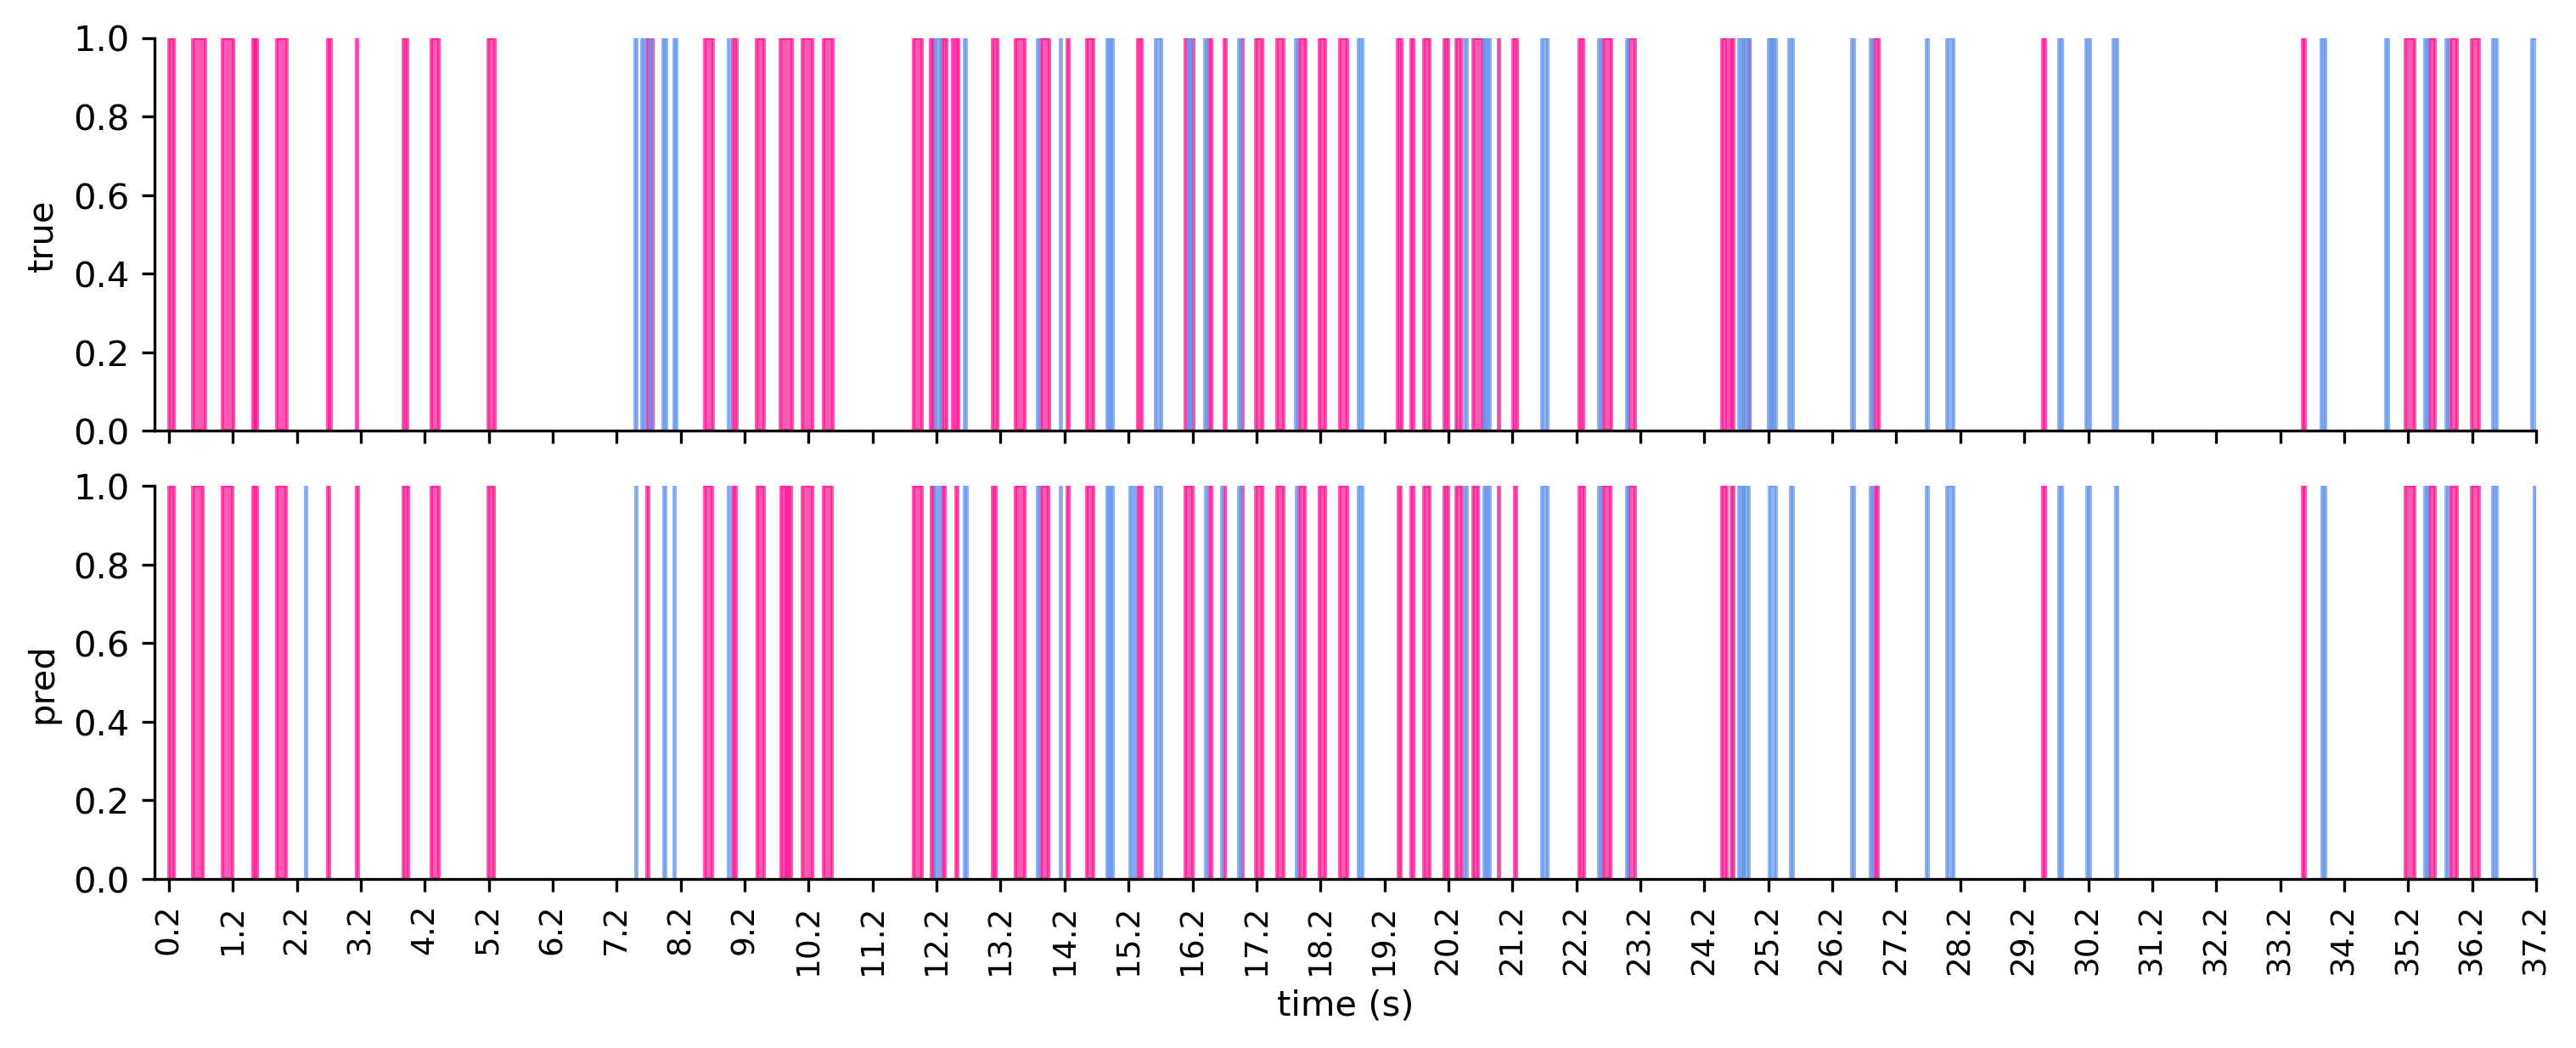

In [19]:


#define the start and stop of the plot
first_voc_start = np.min([list(true_df['start_seconds'])[0], list(predicted['start_seconds'])[0]])
last_voc_end = np.max([list(true_df['stop_seconds'])[-1], list(predicted['stop_seconds'])[-1]]) 

fig, axes = plt.subplots(nrows=2,
                             ncols=1,
                             figsize=[10,4], 
                             dpi=300, 
                             constrained_layout=True
                        )
    
    
axes[0].set_xticklabels([])
axes[0].set_xticks(ticks = np.arange(first_voc_start, last_voc_end, 1))
axes[0].set_xticklabels(labels = [])
axes[0].set_ylabel('true', rotation = 90)
axes[1].set_ylabel('pred')
axes[1].set_xlabel('time (s)')
axes[1].set_xticks(ticks = np.arange(first_voc_start, last_voc_end, 1))
axes[1].set_xticklabels(labels = np.round(np.arange(first_voc_start, last_voc_end, 1),1), fontsize=9, rotation=90)

#voc type names
voc_types = ['squeak', 'USV']
voc_colors = parameters.load_json(vocalization_colors)
box_height = 1
for voc_type in voc_types:

    true_starts = np.array(true_df['start_seconds'].loc[true_df['name'] == voc_type])
    true_stops = np.array(true_df['stop_seconds'].loc[true_df['name'] == voc_type])

    predicted_starts = np.array(predicted['start_seconds'].loc[predicted['voc_type'] == voc_type])
    predicted_stops = np.array(predicted['stop_seconds'].loc[predicted['voc_type'] == voc_type])

    for start, stop in zip(true_starts, true_stops):

        box_length = stop - start
        box = plt.Rectangle((start,0), box_length, box_height, alpha = 0.7, color = voc_colors[voc_type])
        axes[0].add_patch(box)

    for start, stop in zip(predicted_starts, predicted_stops):

        box_length = stop - start
        box = plt.Rectangle((start,0), box_length, box_height, alpha = 0.7, color = voc_colors[voc_type])
        axes[1].add_patch(box)

sns.despine()

In [20]:
#get the annotations
actual = true_df

#a widget that will allow you to scroll through the wav file and show both true and predicted vocs
start = 0 # start of the viewing window in s
length = 4  # end of the viewing window in s
evaluate.plot(predicted=predicted, 
              actual=true_df, 
              wav_path=path_to_wav, 
              window_duration= length/5, 
              step=(length/10)/2, 
              with_spec = True, 
              start_at = start, 
              clip_seconds=[start,start+length], 
              voc_colors = voc_colors)

interactive(children=(FloatSlider(value=0.0, description='window_start', max=3.2, step=0.2), Output()), _dom_c…

## Get features of annotated vocalizations

In [21]:
annotated_features = pd.concat([pd.read_csv(i) for i in glob.glob(os.path.join(annotations_root, 'segment_annotations_acoustic_features', '*.csv'))])
annotated_features = annotated_features.drop(columns = 'Unnamed: 0').reset_index(drop = True)
annotated_features['label'] = annotated_features['label'].map({'cry':'squeak', 'USV':'USV'})
annotated_features['duration'] = annotated_features['duration']*1000

In [22]:
squeak_avg_freq = annotated_features['meandom'][annotated_features['label'] == 'squeak'].median()
squeak_avg_duration = annotated_features['duration'][annotated_features['label'] == 'squeak'].median()
USV_avg_freq = annotated_features['meandom'][annotated_features['label'] == 'USV'].median()
USV_avg_duration = annotated_features['duration'][annotated_features['label'] == 'USV'].median()

In [23]:
squeak_SD_freq = annotated_features['meandom'][annotated_features['label'] == 'squeak'].std()
squeak_SD_duration = annotated_features['duration'][annotated_features['label'] == 'squeak'].std()
USV_SD_freq = annotated_features['meandom'][annotated_features['label'] == 'USV'].std()
USV_SD_duration = annotated_features['duration'][annotated_features['label'] == 'USV'].std()

# Make the figure

/var/folders/h6/6fyt3jld5pq_w03ql1jw0gnh0000gn/T/ipykernel_20920/922572086.py:176: UserWarning: Adding colorbar to a different Figure <Figure size 5100x6600 with 17 Axes> than <Figure size 800x800 with 2 Axes> which fig.colorbar is called on.
  cbar = figure.colorbar(cax, fraction=0.046, pad=0.04)


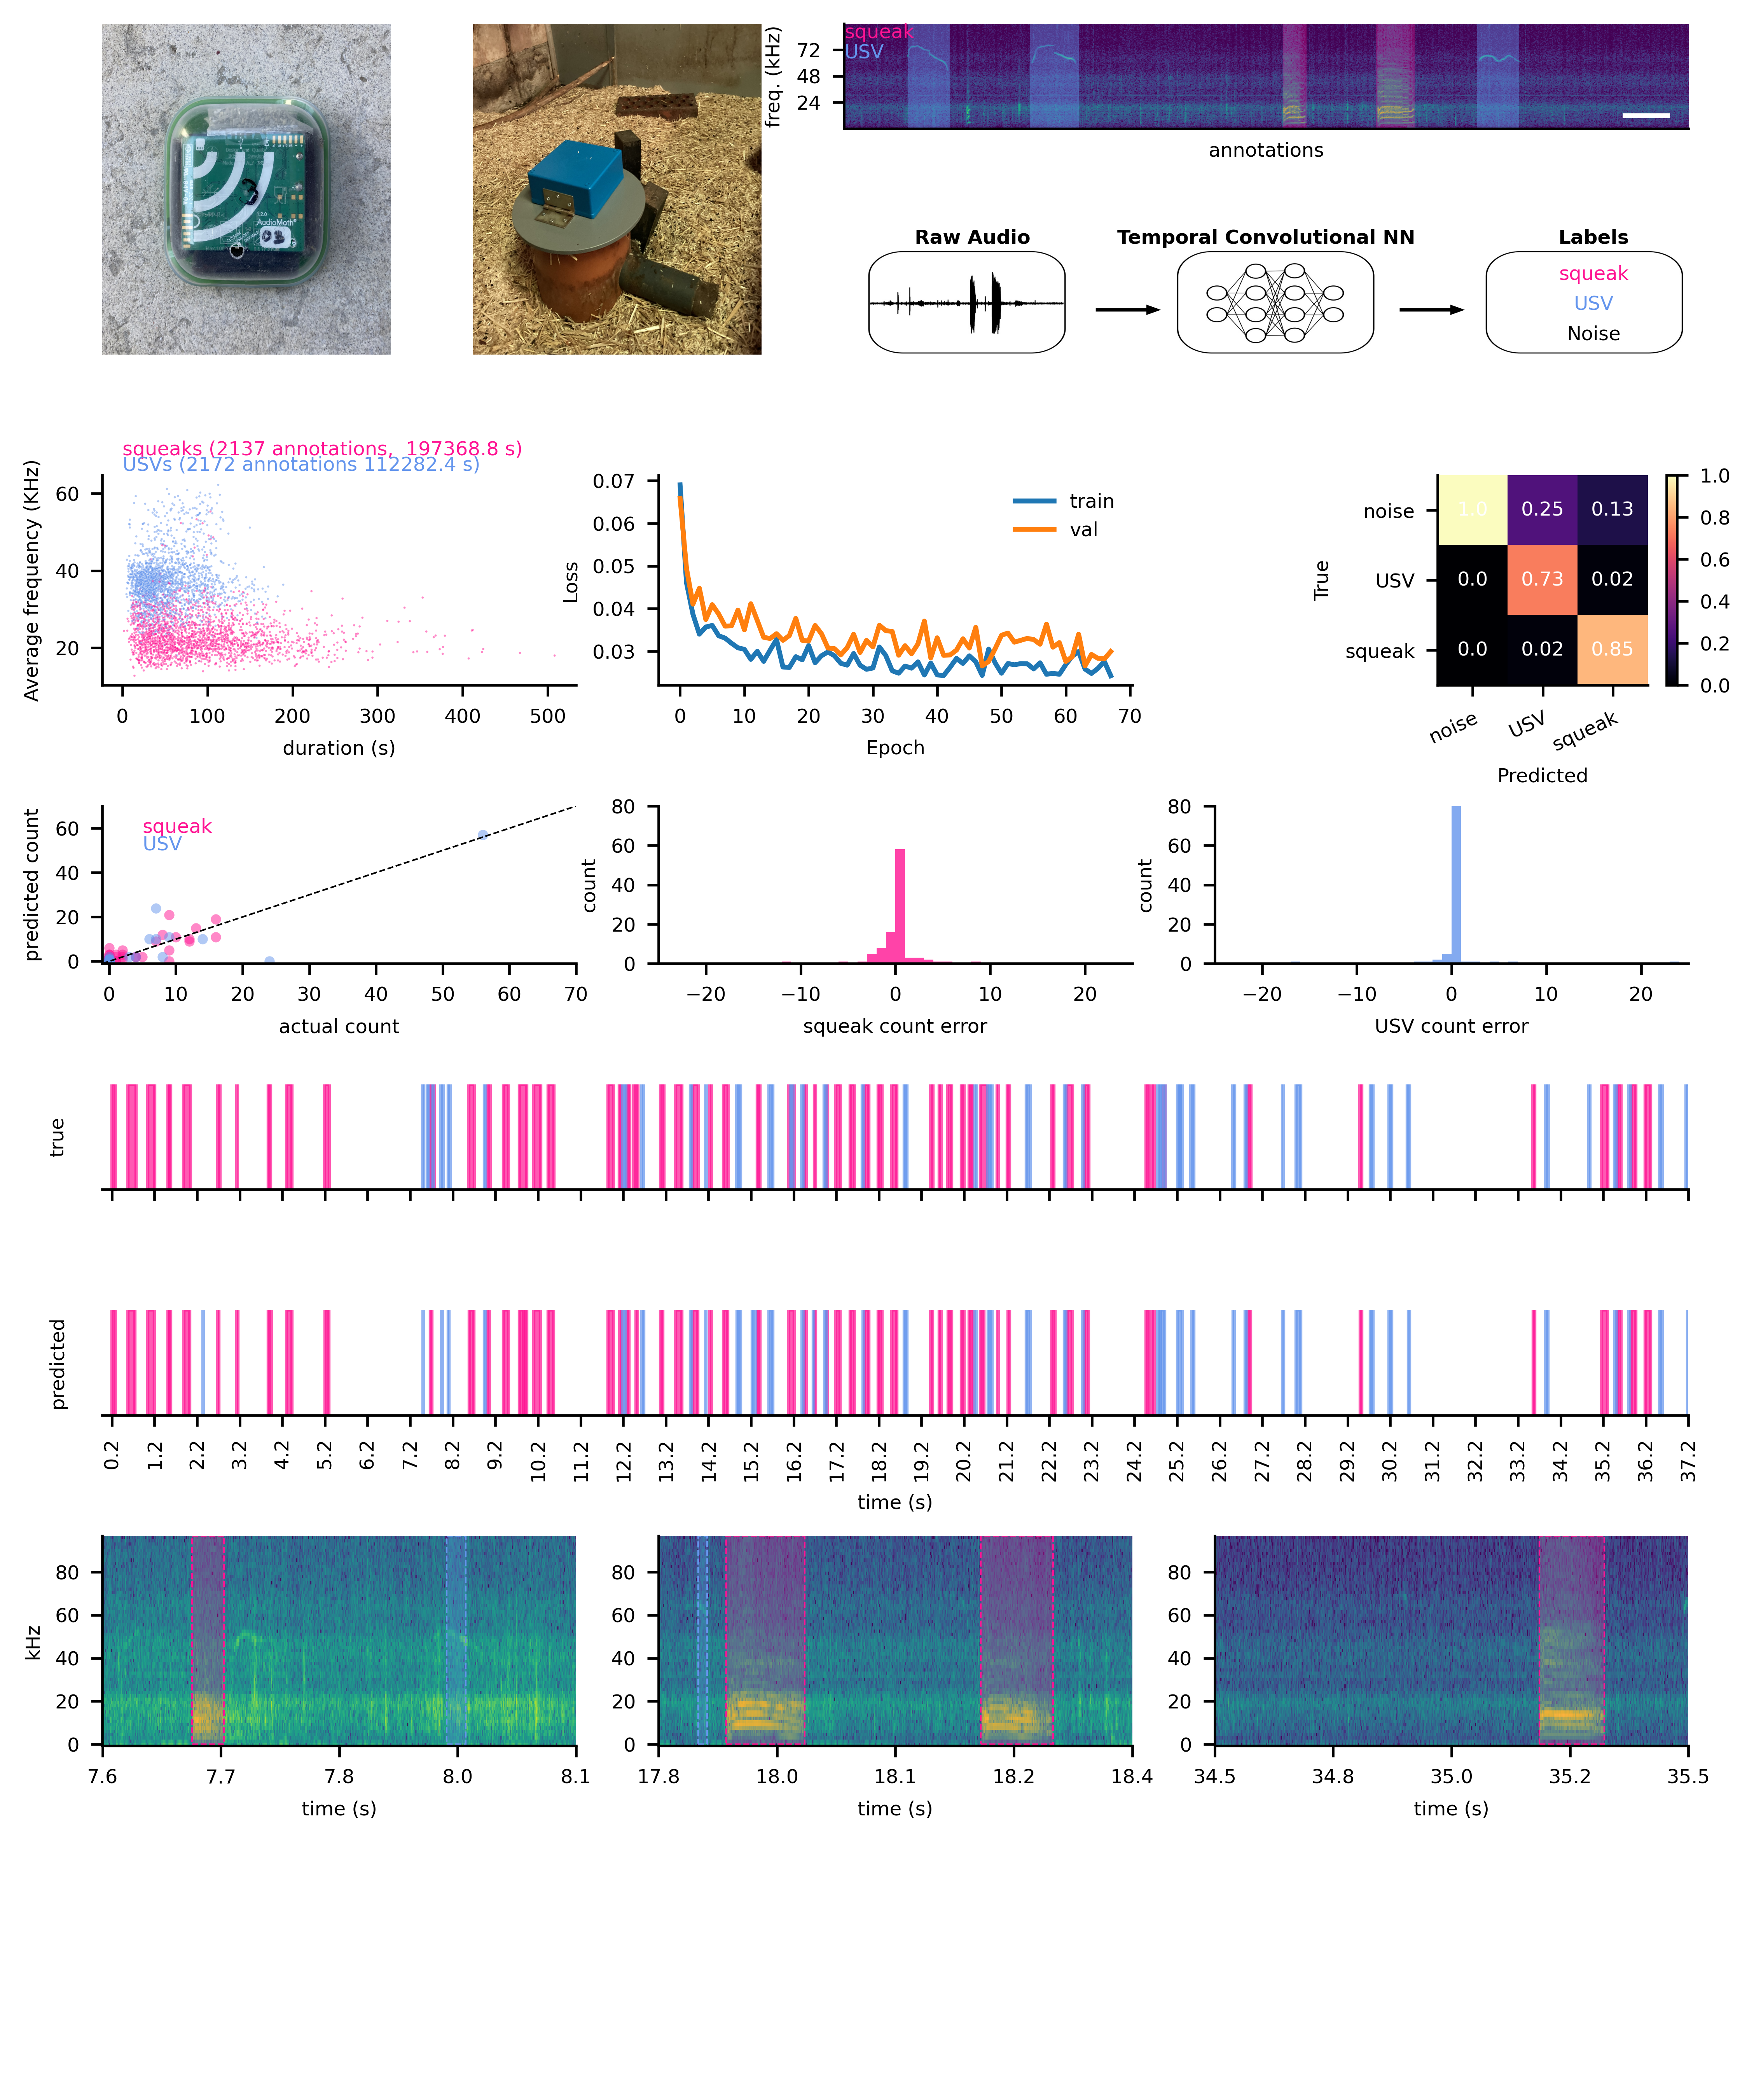

In [24]:
# save or not
save = False
path_to_save = '/Users/jourjine/Desktop/lindholm/barn_manuscript_final/procB_resubmission/resubmission_figures'

######################################################################################################

fig, axes = plt.subplot_mosaic(mosaic="AABBCCCCC;"\
                                      "AABBDDDDD;"\
                                      "aaabbbccc;"\
                                      "dddEEEFFF;"\
                                      "JJJJJJJJJ;"\
                                      "KKKKKKKKK;"\
                                      "LLLMMMNNN;"\
                                      "000000000",
                               figsize=[8.5,11], 
                               constrained_layout=False,
                               gridspec_kw={"height_ratios": [0.5,0.5,1,0.75,0.5,0.5,1, 1]},
                               dpi=600)

axes["0"].axis('off')
# Manually adjust the subplot parameters
plt.subplots_adjust(
    left=0.2,     # Left margin
    right=1,    # Right margin
    top=1,      # Top margin
    bottom=0.2,   # Bottom margin
    wspace=0.8,   # Width space between subplots
    hspace=0.8    # Height space between subplots
)

#plot parameters
tick_label_fontsize = 6
axis_label_fontsize = 9
title_label_fontsize = 12
num_ticks = 10 # for panel F x-axis
dot_size = 10
dot_alpha = .5
voc_colors = {'squeak':'deeppink', 'USV':'cornflowerblue'}

# A = text summary of what you annotated
# B = test/val curves
# C = chunk confusion matrix
# D = actual vs predicted count
# E = hist of cry errors
# F = hist of USV errors
# G = actual vs predicted duration
# H = start error
# I = stop error
# J = predicted segments from entire recording
# K = true segments from same recording
# L = spectrogram zoom onto a true positive (spec plus annotation rectangle)
# M = spectrogram zoom onto a false positive (spec plus annotation rectangle)
# N = spectrogram zoom onto a false negative (spec plus annotation rectangle)

##################################################################################################
### PANELS A and B - intros and schematics
##################################################################################################

#plot the picture

axes["A"].imshow(Image.open(path_to_audio_moth), aspect='auto')
axes["A"].axis("off")

axes["B"].imshow(Image.open(path_to_audio_moth_in_action), aspect='auto') # TODO add a scale bar
axes["B"].axis("off")


##################################################################################################
### PANELS C and D - segmentation schematic
##################################################################################################

#get the audio for the example spectrogram
start, stop = 34, 36
fs, audio = wavfile.read(path_to_example_wav_for_spectrogram)
audio = audio[start*fs:stop*fs]

#plot the spectrogram with scale bar for time
f, t, spec = spectrogramming.make_spec(audio = audio, fs = fs, nperseg = 512, noverlap = 512//4, thresh = 0)
axes["C"].imshow(spec, origin='lower', cmap = 'viridis', aspect='auto')
axes["C"].axhline(y=64.25/2, xmin=925/1000, xmax=975/1000, color='white', linewidth=1.5) #100 ms scale bar for a 2s long clip
axes["C"].set_yticks([64.25, (64.25*2), (64.25*3)])
axes["C"].set_yticklabels(["24", "48", "72"], fontsize=6)
axes["C"].set_ylabel("freq. (kHz)", fontsize=6)
axes["C"].set_xticks([])
axes["C"].set_xticklabels([])

#make the example annotation
USV1 = patches.Rectangle((75, 0), 50, axes["C"].get_ylim()[1], edgecolor='none', facecolor='cornflowerblue', alpha=0.4)
USV2 = patches.Rectangle((220, 0), 58, axes["C"].get_ylim()[1], edgecolor='none', facecolor='cornflowerblue', alpha=0.4)
USV3 = patches.Rectangle((750, 0), 50, axes["C"].get_ylim()[1], edgecolor='none', facecolor='cornflowerblue', alpha=0.4)
squeak1 = patches.Rectangle((520, 0), 28, axes["C"].get_ylim()[1], edgecolor='none', facecolor='deeppink', alpha=0.3)
squeak2 = patches.Rectangle((630, 0), 46, axes["C"].get_ylim()[1], edgecolor='none', facecolor='deeppink', alpha=0.3)
axes["C"].text(x=0,y=axes["C"].get_ylim()[1]-35, s="squeak",fontsize=tick_label_fontsize, horizontalalignment='left', color='deeppink')
axes["C"].text(x=0,y=axes["C"].get_ylim()[1]-85, s="USV",fontsize=tick_label_fontsize, horizontalalignment='left', color='cornflowerblue')

#add them
axes["C"].add_patch(USV1)
axes["C"].add_patch(USV2)
axes["C"].add_patch(USV3)
axes["C"].add_patch(squeak1)
axes["C"].add_patch(squeak2)
axes["C"].set_xlabel('annotations', fontsize=tick_label_fontsize)

#add panel D
axes["D"].imshow(Image.open(path_to_workflow_pic), aspect='auto')
axes["D"].text(x=380,y=-25, s="Raw Audio", fontsize=tick_label_fontsize, horizontalalignment='center', weight='bold')
axes["D"].text(x=1250,y=-25, s="Temporal Convolutional NN", fontsize=tick_label_fontsize, horizontalalignment='center', weight='bold')
axes["D"].text(x=2220,y=-25, s="Labels", fontsize=tick_label_fontsize, horizontalalignment='center', weight='bold')
axes["D"].text(x=2220,y=125, s="squeak", fontsize=tick_label_fontsize, horizontalalignment='center', color='deeppink')
axes["D"].text(x=2220,y=250, s="USV", fontsize=tick_label_fontsize, horizontalalignment='center', color='cornflowerblue')
axes["D"].text(x=2220,y=375, s="Noise", fontsize=tick_label_fontsize, horizontalalignment='center')
axes["D"].add_patch(patches.FancyArrow(x=750, y=250, dx=150, dy=0, width=1, head_width=24, head_length = 24, edgecolor='black', facecolor='black'))
axes["D"].add_patch(patches.FancyArrow(x=1650, y=250, dx=150, dy=0, width=1, head_width=24, head_length = 24, edgecolor='black', facecolor='black'))
axes["D"].axis('off')


##################################################################################################
# panel a - annotation summary - or recordings per box per season?
##################################################################################################

sns.scatterplot(data = annotated_features, 
                x = 'duration', 
                y = 'meanfreq', 
                hue = 'label', 
                s = 0.5, 
                alpha = 0.5, 
                palette = voc_colors,
                ax = axes["a"], 
                legend = False)

annotations = {
    'squeak': 'deeppink',
    'USV': 'cornflowerblue'
}


# Get the upper right corner limits of the scatter plot
num_squeak_annotated = len(annotated_features[annotated_features['label'] == 'squeak'])
duration_squeak_annotated = np.round(annotated_features['duration'][annotated_features['label'] == 'squeak'].sum(), 1)
num_USV_annotated = len(annotated_features[annotated_features['label'] == 'USV'])
duration_USV_annotated = np.round(annotated_features['duration'][annotated_features['label'] == 'USV'].sum(),1)

squeak_label = 'squeaks '+ '('+str(num_squeak_annotated)+' annotations,  ' + str(duration_squeak_annotated) + ' s)'
USV_label = 'USVs '+ '('+str(num_USV_annotated)+' annotations ' + str(duration_USV_annotated) + ' s)'
legend_labels = [squeak_label, USV_label]
legend_colors = ['deeppink', 'cornflowerblue']

for label, color in zip(legend_labels, legend_colors):
    axes["a"].text(0, 70 - legend_labels.index(label)*4, label, color=color, fontsize=tick_label_fontsize)

sns.despine(ax = axes["a"])
axes["a"].tick_params(axis='both', which='major', labelsize=tick_label_fontsize)
axes["a"].set_xlabel('duration (s)', fontsize = tick_label_fontsize)
axes["a"].set_ylabel('Average frequency (KHz)', fontsize = tick_label_fontsize)
##################################################################################################
# panel b - train/val plot
##################################################################################################

#axes["b"].set_title('Model Training', fontsize = tick_label_fontsize)
axes["b"].plot(res['fit_hist']['loss'], label='train')
axes["b"].plot(res['fit_hist']['val_loss'], label='val')
axes["b"].set_xlabel('Epoch', fontsize = tick_label_fontsize)
axes["b"].set_ylabel('Loss', fontsize = tick_label_fontsize)
axes["b"].tick_params(axis='both', which='major', labelsize=tick_label_fontsize)
axes["b"].legend(frameon=False, fontsize=tick_label_fontsize)
sns.despine()

##################################################################################################
# panel c - confusion matrix heatmap
##################################################################################################

labels = ['noise', 'USV', 'squeak']
confusion_matrix = res['confusion_matrix'].T/res['confusion_matrix'].T.sum(axis=0)
confusion_matrix = np.round(confusion_matrix, decimals=2)
cax = axes["c"].imshow(confusion_matrix, cmap='magma', aspect='equal')
cbar = figure.colorbar(cax, fraction=0.046, pad=0.04)
cbar.ax.yaxis.set_tick_params(labelsize=tick_label_fontsize) 
axes["c"].set_xticks(np.arange(len(labels)))
axes["c"].set_yticks(np.arange(len(labels)))
axes["c"].set_xticklabels(labels, fontsize = tick_label_fontsize)
axes["c"].set_yticklabels(labels, fontsize = tick_label_fontsize)
plt.setp(axes["c"].get_xticklabels(), rotation=25, ha="right", rotation_mode="anchor")
for i in range(len(labels)):
    for j in range(len(labels)):
        text = axes["c"].text(j, i, confusion_matrix[i, j],
                       ha="center", va="center", color="w", fontsize = tick_label_fontsize)
axes["c"].set_xlabel('Predicted', fontsize = tick_label_fontsize)
axes["c"].set_ylabel('True', fontsize = tick_label_fontsize)

##################################################################################################
# panel d - true count by actual count
##################################################################################################


axes["d"].scatter(x = comparison_df['actual_squeak_count'], 
                  y = comparison_df['predicted_squeak_count'], 
                  color = 'deeppink', 
                  linewidth = 0, 
                  s = dot_size, 
                  alpha = dot_alpha)
axes["d"].scatter(x = comparison_df['actual_USV_count'], 
                  y = comparison_df['predicted_USV_count'], 
                  color = 'cornflowerblue', 
                  alpha = dot_alpha, 
                  s = dot_size, 
                  linewidth = 0)

axes["d"].set_xlim([-1,70])
axes["d"].set_ylim([-1,70])
legend_labels = ['squeak', 'USV']
legend_colors = ['deeppink', 'cornflowerblue']
for label, color in zip(legend_labels, legend_colors):
    axes["d"].text(5, 58 - legend_labels.index(label)*8, label, color=color, fontsize=tick_label_fontsize)
axes["d"].set_xlabel('actual count', fontsize = tick_label_fontsize)
axes["d"].set_ylabel('predicted count', fontsize = tick_label_fontsize)
axes["d"].axline((0,0), slope=1, color = 'black', linestyle = '--', linewidth=.5)
axes["d"].tick_params(axis='both', which='major', labelsize=tick_label_fontsize)


##################################################################################################
# panel E - distribution of count errors for squeaks
##################################################################################################

sns.histplot(data=errors_df.loc[errors_df['voc_type']=='squeak'], 
             x='error', 
             hue='voc_type',
             ax=axes["E"], 
             palette = voc_colors, 
             linewidth=0, 
             alpha=0.8, 
             binwidth=1, 
             legend=False)
axes["E"].set_xlabel('squeak count error', fontsize=tick_label_fontsize)
axes["E"].set_ylabel('count', fontsize = tick_label_fontsize)
axes["E"].tick_params(axis='both', which='major', labelsize=tick_label_fontsize)
axes["E"].set_ylim([0,80])
axes["E"].set_xlim([-25,25])

##################################################################################################
# panel F - distribution of count errors for USVs
##################################################################################################

sns.histplot(data=errors_df.loc[errors_df['voc_type']=='USV'], 
             x='error', 
             hue='voc_type',
             ax=axes["F"], 
             palette = voc_colors, 
             linewidth=0, 
             alpha=.8, 
             binwidth=1, legend=False)
axes["F"].set_xlabel('USV count error', fontsize=tick_label_fontsize)
axes["F"].set_ylabel('count', fontsize = tick_label_fontsize)
axes["F"].tick_params(axis='both', which='major', labelsize=tick_label_fontsize)
axes["F"].set_ylim([0,80])
axes["F"].set_xlim([-25,25])



##################################################################################################
# panel J and K - actual and predicted segments
##################################################################################################

axes["J"].set_xticklabels([])
axes["J"].set_xticks(ticks = np.arange(first_voc_start, last_voc_end, 1))
axes["J"].set_xticklabels(labels = [])
axes["J"].set_yticklabels(labels = [])
axes["J"].spines['left'].set_visible(False)
axes["J"].spines['right'].set_visible(False)
axes["J"].tick_params(axis='y', which='both', left=False, right=False)
axes["J"].set_ylabel('true', fontsize=tick_label_fontsize)

axes["K"].tick_params(axis='y', which='both', left=False, right=False)
axes["K"].set_xticklabels(labels = [])
axes["K"].set_yticklabels(labels = [])
axes["K"].spines['left'].set_visible(False)
axes["K"].spines['right'].set_visible(False)
axes["K"].set_ylabel('predicted', fontsize=tick_label_fontsize)
axes["K"].set_xlabel('time (s)', fontsize=tick_label_fontsize)
axes["K"].set_xticks(ticks = np.arange(first_voc_start, last_voc_end, 1))
axes["K"].tick_params(axis='y', which='major', labelsize=tick_label_fontsize)
axes["K"].set_xticklabels(labels = np.round(np.arange(first_voc_start, last_voc_end, 1),1), 
                          fontsize=tick_label_fontsize, 
                          rotation=90)

#voc type names
voc_types = ['squeak', 'USV']
voc_colors = parameters.load_json(vocalization_colors)
box_height = 1

first_voc_start = np.min([list(true_df['start_seconds'])[0], list(predicted['start_seconds'])[0]])
last_voc_end = np.max([list(true_df['stop_seconds'])[-1], list(predicted['stop_seconds'])[-1]]) 
for voc_type in voc_types:

    true_starts = np.array(true_df['start_seconds'].loc[true_df['name'] == voc_type])
    true_stops = np.array(true_df['stop_seconds'].loc[true_df['name'] == voc_type])

    predicted_starts = np.array(predicted['start_seconds'].loc[predicted['voc_type'] == voc_type])
    predicted_stops = np.array(predicted['stop_seconds'].loc[predicted['voc_type'] == voc_type])

    for start, stop in zip(true_starts, true_stops):

        box_length = stop - start
        box = plt.Rectangle((start,0), box_length, box_height, alpha = 0.7, color = voc_colors[voc_type])
        axes["J"].add_patch(box)

    for start, stop in zip(predicted_starts, predicted_stops):

        box_length = stop - start
        box = plt.Rectangle((start,0), box_length, box_height, alpha = 0.7, color = voc_colors[voc_type])
        axes["K"].add_patch(box)

##################################################################################################
# panel L, M, N - spectrogram examples with predictions
##################################################################################################

# the size of the clip
start_times, durations = [7.6, 17.8, 34.5], [0.5, 0.6, 1]
stop_times = [start_time + duration for start_time, duration in zip(start_times, durations)]

for ax, start_time, stop_time in zip(["L", "M", "N"], start_times, stop_times):
    
    #subset the predicted vocalizations
    predicted_for_plot = predicted[(predicted['start_seconds'] > start_time) & (predicted['stop_seconds'] < stop_time)]

    # Load the audio
    y, sr = librosa.load(path_to_wav, sr=192000)

    # Clip the audio
    start_sample = int(np.round(start_time * sr))
    stop_sample = int(np.round(stop_time * sr))
    y = y[start_sample:stop_sample]

    # Make the spectrogram
    n_fft = 128
    hop_length = n_fft // 4
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=None, window='hann', center=True, pad_mode='constant')
    specgram = librosa.amplitude_to_db(np.abs(D), ref=np.max)

    librosa.display.specshow(specgram, 
                             hop_length=hop_length, 
                             cmap='viridis', 
                             ax=axes[ax], 
                             x_axis='s', 
                             y_axis='linear', 
                             sr=sr)

    Hz_values = axes[ax].get_yticks()
    axes[ax].set_yticks(np.arange(0, np.max(Hz_values), 20000))
    axes[ax].tick_params(axis='both', which='major', labelsize=tick_label_fontsize)
    axes[ax].set_yticklabels([int(i) for i in np.arange(0, np.max(Hz_values), 20000) / 1000], fontsize=tick_label_fontsize)
    
    xtick_locs = np.linspace(0, stop_time - start_time, num=5)
    xtick_labels = np.round(np.linspace(start_time, stop_time, num=5), 1)
    axes[ax].set_xticks(xtick_locs)
    axes[ax].set_xticklabels(xtick_labels, fontsize=tick_label_fontsize)
    #axes[ax].set_xticklabels(labels = np.round(np.arange(start_time, stop_time, 0.1),1), fontsize=tick_label_fontsize)
    
    if ax == "L":
        axes[ax].set_ylabel('kHz', fontsize=tick_label_fontsize)
    else:
        axes[ax].set_ylabel('')
    axes[ax].set_xlabel('time (s)', fontsize=tick_label_fontsize)

    # Plot predictions on top of spectrogram
    y_scale = axes[ax].get_ylim()[1]  
    box_height = y_scale
    for voc_type in ['squeak', 'USV']:

        predicted_starts = np.array(predicted_for_plot['start_seconds'][predicted_for_plot['voc_type'] == voc_type])
        predicted_durations = np.array(predicted_for_plot['duration'][predicted_for_plot['voc_type'] == voc_type])

        for start, stop, duration in zip(predicted_starts, predicted_stops, predicted_durations):
            start = start - start_time
            box_length = duration
            box = plt.Rectangle((start, 0), 
                                box_length, 
                                box_height, 
                                facecolor=voc_colors[voc_type], 
                                linewidth = .5, 
                                edgecolor = voc_colors[voc_type], 
                                linestyle = '--')
            box.set_facecolor((*box.get_facecolor()[:3], 0.25))  # Set face alpha to 0.25
            box.set_edgecolor((*box.get_edgecolor()[:3], 1)) # Set edge alpha to 1
            axes[ax].add_patch(box)

if save:
    plt.savefig(os.path.join(path_to_save, 'Supplemental_Figure3_revision_v1.jpeg'), dpi = 600)
    plt.savefig(os.path.join(path_to_save, 'Supplemental_Figure3_revision_v1.svg'), dpi = 600)